<a href="https://colab.research.google.com/github/RoitRapha/FUEP21-22_XAI/blob/main/XAI_SHAP_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Artificial Intelligence on Time Series Data using the SHAP Algorithm


##Team and project  description
*This notebook is the documentation of the result of an university project work of the HTW university of applied science. Developed by a group of Master students in mechanical engineering. The aim is to investigate different methods for determining relevant properties of the classification. For this purpose, forms of dimension reduction are also to be considered. The results from this are to be suitably visualized and evaluated with previously defined criteria.*

**Team members:**


*   Paul-Albert Bartlau
*   Maurice Lucas Dörnte
*   Tim Dieter Eberhardt
*   Tim Lukas Schröter
*   Raphael Wallsberger




##Methods

*In this work, the XAI algorithm SHAP and the dimensionality reduction method UMAP were selected for further determination of relevant properties. The UMAP algorithm achieves very good results on high dimensional data and comparatively preserves the global and local relationships of the dataset very well. The SHAP algorithm is based on the "shapley values" and thus on a solid theoretical (game theory) and mathematical foundation. Especially the latter strengthens the acceptance of the method. Moreover, both local and global explanations can be performed and the predictions are evenly distributed over the feature values. Furthermore, SHAP has a TreeSHAP library that can be applied to tree algorithms and has very short computation time. Other SHAP variants, such as KernelSHAP, are very time and computationally intensive and practically difficult to apply.
In the first step, UMAP is now applied to the dataset to investigate the shapes of the individual class clusters, as well as their relative positions to each other. Also, a suitable tree algorithm is trained on the dataset as a classifier, in this case the XGBoost library. On the one hand because simple trees achieve good results, which are still comprehensible by humans, and on the other hand because of the aforementioned good applicability of TreeSHAP. The good accuracies (Accuracies - Acc) and F1-Scores speak for XGBoost in comparison to SVM and KNN . The next step is a selection of the hyperparameters of the model with different evaluation metrics (F1, Acc,..). The SHAP algorithm is applied to the XGBoost model. Results from this should be the 10 most important features of the classification, which are presented in a suitable form.
The following evaluation system is defined to be able to classify the results and the quality. On the one hand, the metrics Accuracy and F1-Score of the XGBoost are compared with different training data. On the other hand, other types of models (KNN and SVM) are trained with these data and their key figures are also evaluated. The three training datasets consist of: 1. the whole dataset, 2. the 10 most important features from TreeSHAP and 3. 10 random features. 
For an additional auditory representation of the most important features, the data is extracted and then made audible. The extraction includes only the 10 most important features of the data set, the remaining values of the other features are set to zero. Now the data can be transformed from the frequency domain back to the time domain. In the last step, a sound file for each class is generated from the cleaned data. These should give an indication of the type of error when listening.*

## Initial

Install SHAP Library:

In [ ]:
!pip install shap
!pip install xgboost
!pip install umap-learn
!pip install plotly
!pip install plotly_express

import shap

import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import csv

import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

from xgboost import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import seaborn as sns
import umap
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})



shap.initjs()

## Data Preperation

### Dataset
The used dataset is from the following paper and you can download it with the following link:

*Paper: S. Matzka, J. Pilz and A. Franke, "Structure-borne and Air-borne Sound Data for Condition Monitoring Applications," 2021 4th International Conference on Artificial Intelligence for Industries (AI4I), 2021, pp. 1-4, doi: 10.1109/AI4I51902.2021.00009.*

Link: https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset



Here, dataset is prapared for further use and training. The class "off" was removed, since this can be easily determined in real environments in industry without artificial intelligence. Furthermore the two labels "Label" and "Timestamp" are dropped because they are not needed for the training and redundant. 

In [ ]:
path_to_data = "frequencyFeatures.csv"

#read in the data using pandas
raw_data = pd.read_csv(path_to_data)

#check data has been read in properly
raw_data.head()


# Delete the two features
raw_data = raw_data.drop(['Label', 'Timestamp'], axis=1)

#keeping entirety of raw data for UMAP
raw_dat_all=raw_data

# Delete the label "off"
raw_data = raw_data.iloc[250:, :]

raw_data

,ID,xAcc010Hz,xAcc015Hz,xAcc020Hz,xAcc025Hz,xAcc030Hz,xAcc035Hz,xAcc040Hz,xAcc045Hz,xAcc050Hz,...,snd2275Hz,snd2300Hz,snd2325Hz,snd2350Hz,snd2375Hz,snd2400Hz,snd2425Hz,snd2450Hz,snd2475Hz,snd2500Hz
250,2,454.729201,373.662293,841.151061,740.903054,335.169305,1277.359858,2338.590535,9415.907494,11120.59792,...,2.081464,2.573535,2.920927,4.982745,3.420132,0.867515,4.606851,2.301164,3.850050,2.092610
251,2,183.645769,320.688104,604.463776,746.636921,417.433785,1024.675231,2260.370181,9701.824416,12373.64882,...,1.899494,4.541002,5.725692,3.447297,2.802118,1.385863,2.985951,3.087122,5.687176,1.633761
252,2,192.824680,197.466285,237.154490,545.014362,524.603158,858.507832,356.197129,8766.841994,12655.39475,...,3.947479,4.772883,9.668906,3.489168,2.272290,2.577190,2.675607,5.028594,5.148495,2.285906
253,2,444.692309,607.832208,311.244219,598.615257,557.446143,644.497740,1136.291001,9139.170561,12116.00045,...,3.838190,3.088682,11.496789,2.656639,2.551696,2.951968,3.115344,3.571959,2.862464,4.497884
254,2,806.189855,213.300371,719.645236,379.386502,261.768009,13.231422,569.551468,9577.904815,12135.93629,...,2.575419,2.697834,7.483828,1.691467,2.032943,1.919057,1.855661,0.584894,0.871019,4.263095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8,734.684640,385.405156,2422.030460,3666.688023,1331.591958,295.834974,615.946313,8784.043068,12981.34632,...,1.810877,4.199799,3.196192,4.824971,5.501506,2.569931,2.769503,2.864246,4.875627,3.097777
1996,8,427.768727,478.715371,1667.903389,3555.054589,1412.465945,546.736119,755.346273,9108.426555,13018.32149,...,5.296502,1.327645,2.921181,4.135513,7.574796,4.394050,1.986867,3.715002,7.698977,3.895627
1997,8,183.683706,244.413614,1889.702322,3486.772611,1175.411282,844.245959,1166.437422,9453.092350,13172.74271,...,8.563501,3.625357,9.565385,2.401314,8.655602,3.706591,4.951512,3.277185,9.806276,3.751800
1998,8,231.417381,290.299651,2107.940465,3431.216806,1618.341691,977.230736,577.816480,9787.239494,13983.28469,...,8.862310,4.188897,13.152540,1.534665,6.803201,1.311985,3.673036,2.172725,7.631238,0.765262


### Make the data machine readable

In [ ]:
# Input
x = raw_data.iloc[:,1:]
x

,xAcc010Hz,xAcc015Hz,xAcc020Hz,xAcc025Hz,xAcc030Hz,xAcc035Hz,xAcc040Hz,xAcc045Hz,xAcc050Hz,xAcc055Hz,...,snd2275Hz,snd2300Hz,snd2325Hz,snd2350Hz,snd2375Hz,snd2400Hz,snd2425Hz,snd2450Hz,snd2475Hz,snd2500Hz
250,454.729201,373.662293,841.151061,740.903054,335.169305,1277.359858,2338.590535,9415.907494,11120.59792,1928.316140,...,2.081464,2.573535,2.920927,4.982745,3.420132,0.867515,4.606851,2.301164,3.850050,2.092610
251,183.645769,320.688104,604.463776,746.636921,417.433785,1024.675231,2260.370181,9701.824416,12373.64882,3476.686256,...,1.899494,4.541002,5.725692,3.447297,2.802118,1.385863,2.985951,3.087122,5.687176,1.633761
252,192.824680,197.466285,237.154490,545.014362,524.603158,858.507832,356.197129,8766.841994,12655.39475,3868.676734,...,3.947479,4.772883,9.668906,3.489168,2.272290,2.577190,2.675607,5.028594,5.148495,2.285906
253,444.692309,607.832208,311.244219,598.615257,557.446143,644.497740,1136.291001,9139.170561,12116.00045,2279.163995,...,3.838190,3.088682,11.496789,2.656639,2.551696,2.951968,3.115344,3.571959,2.862464,4.497884
254,806.189855,213.300371,719.645236,379.386502,261.768009,13.231422,569.551468,9577.904815,12135.93629,2695.609799,...,2.575419,2.697834,7.483828,1.691467,2.032943,1.919057,1.855661,0.584894,0.871019,4.263095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,734.684640,385.405156,2422.030460,3666.688023,1331.591958,295.834974,615.946313,8784.043068,12981.34632,3787.797930,...,1.810877,4.199799,3.196192,4.824971,5.501506,2.569931,2.769503,2.864246,4.875627,3.097777
1996,427.768727,478.715371,1667.903389,3555.054589,1412.465945,546.736119,755.346273,9108.426555,13018.32149,3303.707073,...,5.296502,1.327645,2.921181,4.135513,7.574796,4.394050,1.986867,3.715002,7.698977,3.895627
1997,183.683706,244.413614,1889.702322,3486.772611,1175.411282,844.245959,1166.437422,9453.092350,13172.74271,2768.350699,...,8.563501,3.625357,9.565385,2.401314,8.655602,3.706591,4.951512,3.277185,9.806276,3.751800
1998,231.417381,290.299651,2107.940465,3431.216806,1618.341691,977.230736,577.816480,9787.239494,13983.28469,3668.794806,...,8.862310,4.188897,13.152540,1.534665,6.803201,1.311985,3.673036,2.172725,7.631238,0.765262


In [ ]:
# Output
y = raw_data.iloc[:,0]
y

250     2
251     2
252     2
253     2
254     2
       ..
1995    8
1996    8
1997    8
1998    8
1999    8
Name: ID, Length: 1750, dtype: int64

In [ ]:
# Split the data in 80% Train and 20% Test Sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

## Data Analysis

### UMAP

To get an overall feeling for the data structure a function capable of performing tSNE, PCA, TSVD and UMAP is applied. The best preservation of the global and local structure can be obtained by UMAP. Therefor a 2D-UMAP-plot (Uniform Manifold Approximation and Projection) of the frequency data set is conducted. For learning the embedding the entirety of the data set (raw_dat_all) is used.
1. The "plot_scatter"-function is introduced. Available modes: 'TSNE', 'PCA', 'TSVD', 'UMAP'
2. The "plot_scatter"-function is applied with the "UMAP"-mode 

In [ ]:
X = raw_dat_all.drop(['ID'], axis = 1).values
Y = raw_dat_all["ID"].values

# Plots-Method from Kaggle (don´t Run)
def plot_scatter(X, Y, mode='TSNE', fname='file.png'):
    if mode == 'TSNE':
        X_r = TSNE(n_components=2, random_state=SEED, learning_rate = 'auto', init = 'random').fit_transform(X)
    elif mode == 'PCA':
        X_r = PCA(n_components=2, random_state=SEED).fit_transform(X)
    elif mode == 'TSVD':
        X_r = TruncatedSVD(n_components=2, random_state=SEED).fit_transform(X)
    elif mode =='UMAP':
        reducer = umap.UMAP(n_components = 2, random_state = 42)
        X_r = reducer.fit_transform(X)
        #X_r = umap.UMAP(n_components = 2, random_state = SEED).fit_tansform(X)
    else:
        print('[ERROR]: Please select a valid mode')
        return
    
    traces = []
    traces.append(go.Scatter(x=X_r[Y == 1, 0], y=X_r[Y == 1, 1] , mode='markers', showlegend = True, name='off'))
    traces.append(go.Scatter(x=X_r[Y == 2, 0], y=X_r[Y == 2, 1] , mode='markers', showlegend = True, name='on'))
    traces.append(go.Scatter(x=X_r[Y == 3, 0], y=X_r[Y == 3, 1] , mode='markers', showlegend = True, name='cap'))
    traces.append(go.Scatter(x=X_r[Y == 4, 0], y=X_r[Y == 4, 1] , mode='markers', showlegend = True, name='out'))
    traces.append(go.Scatter(x=X_r[Y == 5, 0], y=X_r[Y == 5, 1] , mode='markers', showlegend = True, name='unb'))
    traces.append(go.Scatter(x=X_r[Y == 6, 0], y=X_r[Y == 6, 1] , mode='markers', showlegend = True, name='c25'))
    traces.append(go.Scatter(x=X_r[Y == 7, 0], y=X_r[Y == 7, 1] , mode='markers', showlegend = True, name='c75'))
    traces.append(go.Scatter(x=X_r[Y == 8, 0], y=X_r[Y == 8, 1] , mode='markers', showlegend = True, name='vnt'))

    layout = dict(title=f'{mode} Plot')
    fig = go.Figure(data=traces, layout=layout)
    py.iplot(fig, filename=fname)

In [ ]:
plot_scatter(X, Y, mode='UMAP', fname='UMAP.png')

The UMAP-projection is showing, that the classes "c25", "c75" and "unb" are mixing up in particular and therefor further investigation seems reasonable.

## Create a Model (Tree)


### Training

*Training 12 models with varying max depth*

In [ ]:

results = pd.DataFrame()
acc_data = []
f1_data = []

for maximale_depth in range(1,13):

    print("_____________________________________________________________________________")
    print("Train new Model: max_depth:", maximale_depth)


    # train the model
    model = xgboost.XGBClassifier(silent = 0, max_depth = maximale_depth)
    model.fit(x_train, y_train)
    
    # Predict
    y_pred = model.predict(x_test)

    # Calculate Acc
    acc = accuracy_score(y_test.to_numpy(), y_pred)
    acc_data.append(acc)

    # Calculate F1
    f1_value = f1_score(y_test, y_pred, average=None)
    f1_data.append(f1_value)
    
    # calculate Confusion Matrix & Precision & Recall
    print(metrics.classification_report(y_test, y_pred))
    print("")
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test,y_pred))
    print("")

    print("Done training -_> Acc:", acc) 
    print("")
    print("")
    #print(" F1:", f1_value)

    # safe the tree parameters
    results = results.append([[]], ignore_index=True, sort=False)
    results = results.append([['Class',id, 'Tree', 'max_depth:', maximale_depth,'Acc:', acc]], ignore_index=True, sort=False)




_____________________________________________________________________________
Train new Model: max_depth: 1
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        47
           5       0.93      0.93      0.93        43
           6       0.76      0.74      0.75        47
           7       0.78      0.80      0.79        45
           8       1.00      1.00      1.00        54

    accuracy                           0.93       350
   macro avg       0.92      0.92      0.92       350
weighted avg       0.93      0.93      0.93       350


Confusion matrix:
[[54  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 47  0  0  0  0]
 [ 0  0  0 40  3  0  0]
 [ 0  0  0  2 35 10  0]
 [ 0  0  0  1  8 36  0]
 [ 0  0  0  0  0  0 54]]

Done training -_> Acc: 0.9314285714285714


______________________________________________________________

### Evaluate Tree

*Plot of accuracy over max depth*

Text(0, 0.5, 'Accuracy')

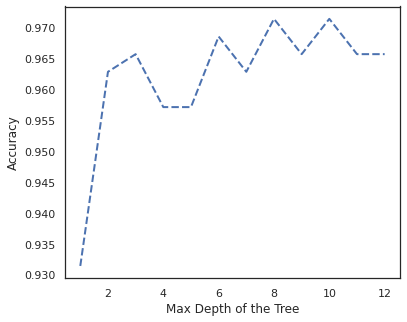

In [ ]:
plt.figure(figsize=(6, 5))

y_plot = acc_data
x_plot = [1,2,3,4,5,6,7,8,9,10,11,12]

plt.plot(x_plot, y_plot, '--', linewidth= 2 )
plt.xlabel('Max Depth of the Tree')
plt.ylabel('Accuracy')


## TreeSHAP with XGBoost
### Train and analyse the choosen Tree

Acc:  0.9657142857142857


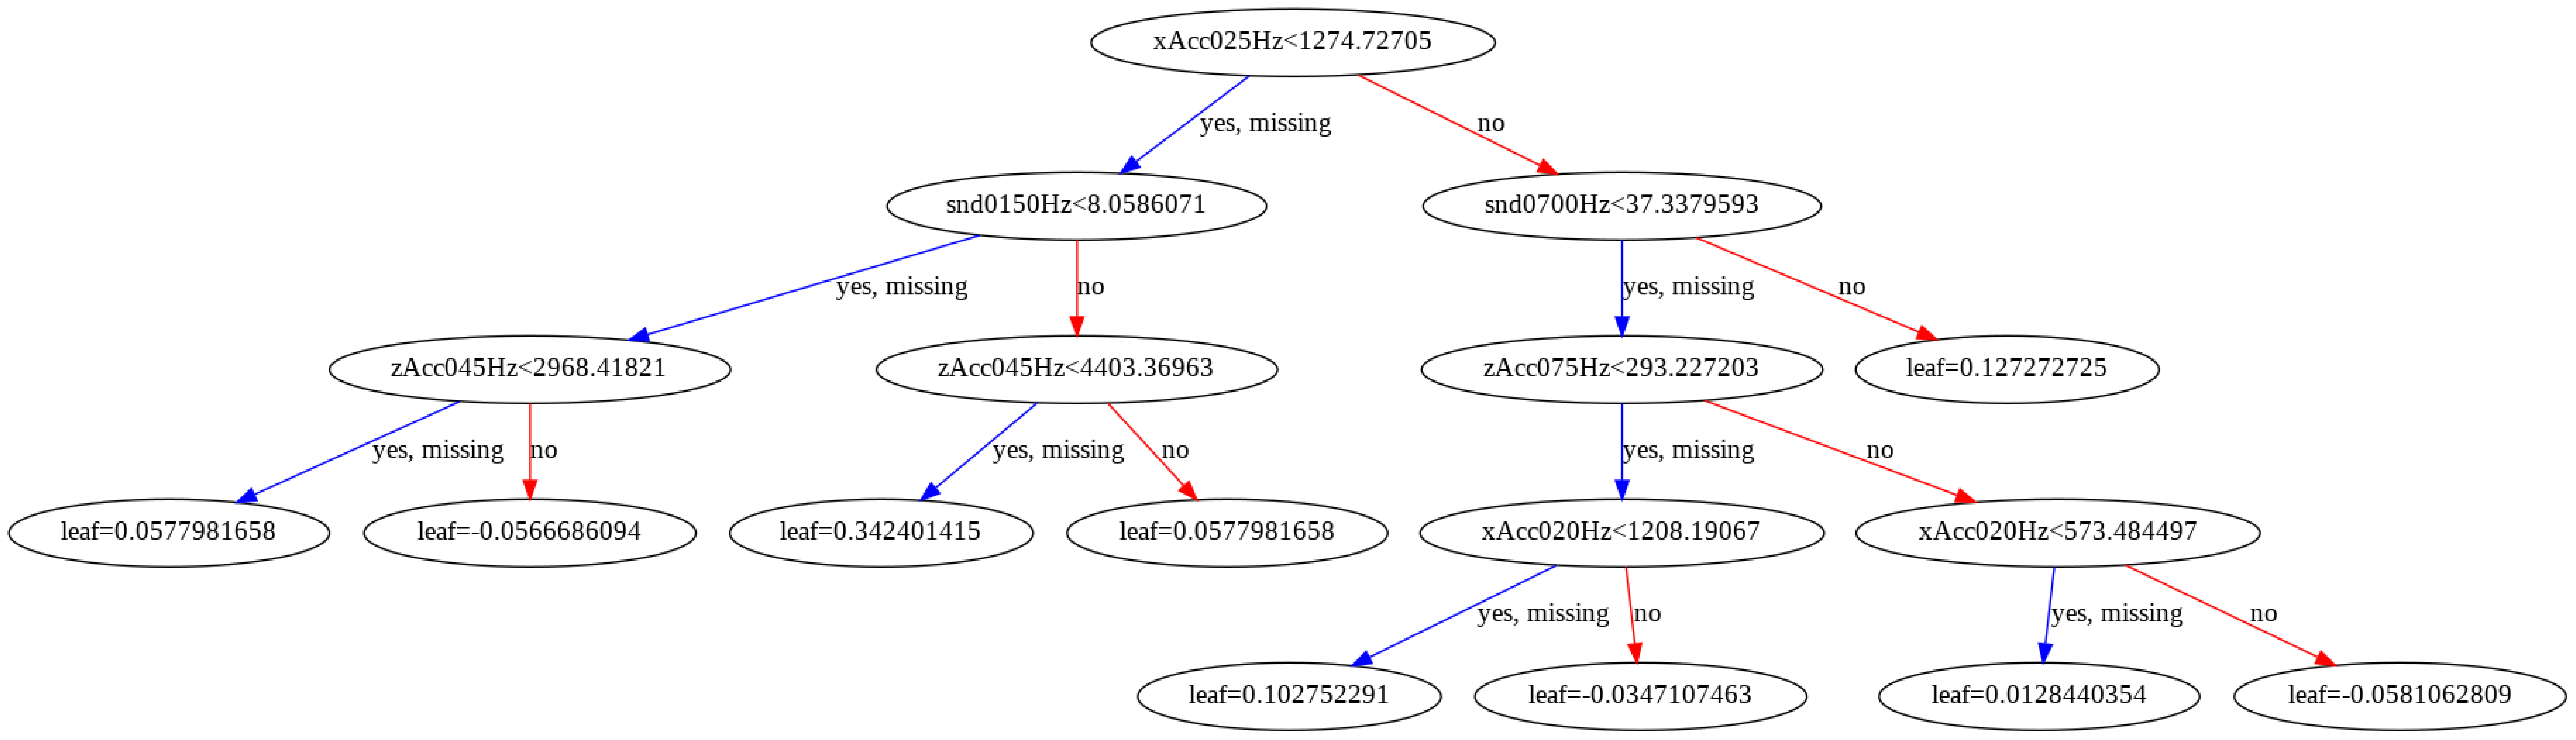

In [ ]:
# data must be a numpy array
np_y_test = y_test.to_numpy()

# Train
model = xgboost.XGBClassifier(silent = 0,
                              max_depth = 6)
model.fit(x_train, y_train)

# Print Acc
print("Acc: ", accuracy_score(y_test.to_numpy(), y_pred))

# Plot the tree
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(200, 200)
plt.show()


Explain the model's predictions on the entire dataset - global

In [ ]:
#SHAP
shap_values = shap.TreeExplainer(model).shap_values(x)
print("1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt")

1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt


mean(SHAP) for all classes and features with labels

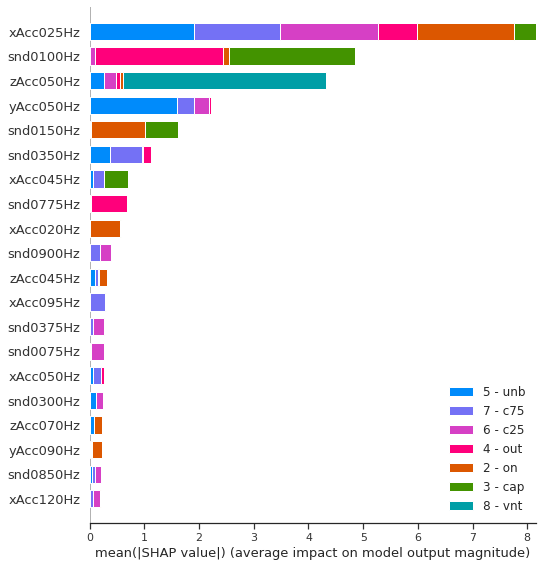

In [ ]:
class_names = ['2 - on', '3 - cap', '4 - out', '5 - unb', '6 - c25', '7 - c75','8 - vnt']
shap.summary_plot(shap_values, x, plot_type="bar",class_names=class_names, feature_names = x.columns)

mean(SHAP) for every class seperatly:

2 - on (magenta)




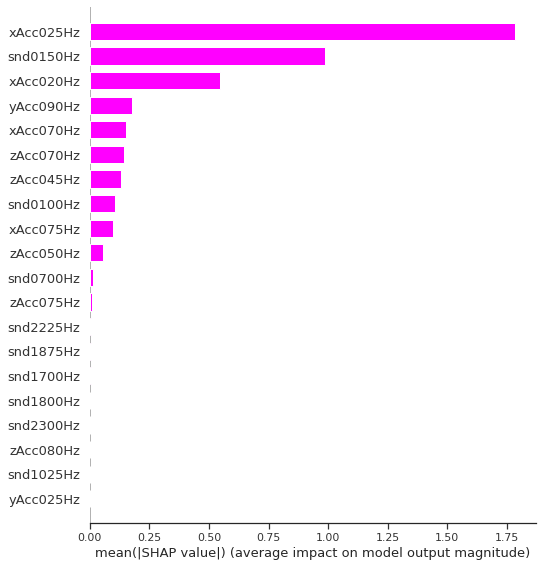

In [ ]:
shap.summary_plot(shap_values[0], x, plot_type="bar", color="magenta")

3 - cap (cyan)

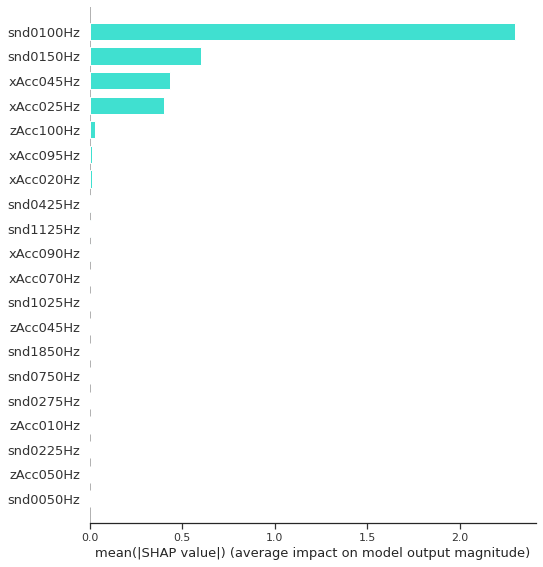

In [ ]:
shap.summary_plot(shap_values[1], x, plot_type="bar", color="turquoise")

4 - out (purple)

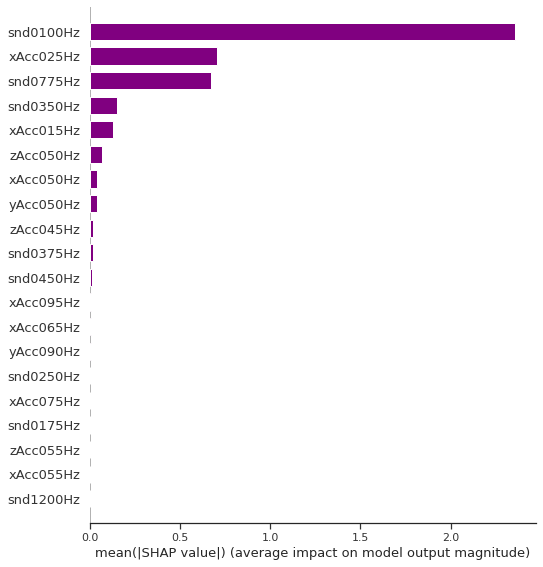

In [ ]:
shap.summary_plot(shap_values[2], x, plot_type="bar", color="purple")

5 - unb (blue)

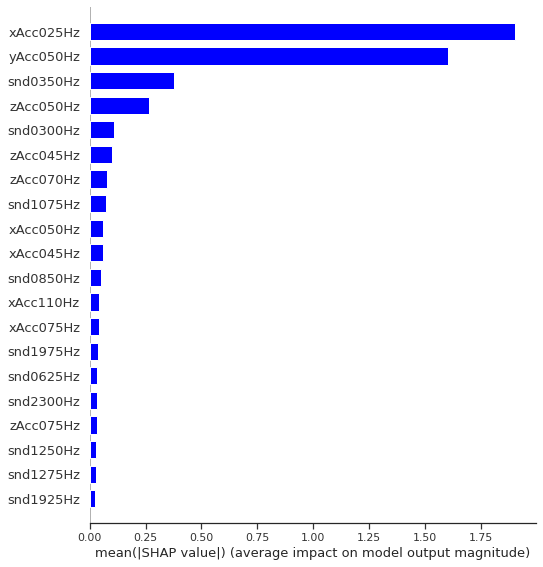

In [ ]:
shap.summary_plot(shap_values[3], x, plot_type="bar", color="blue")

6 - c25 (orange)

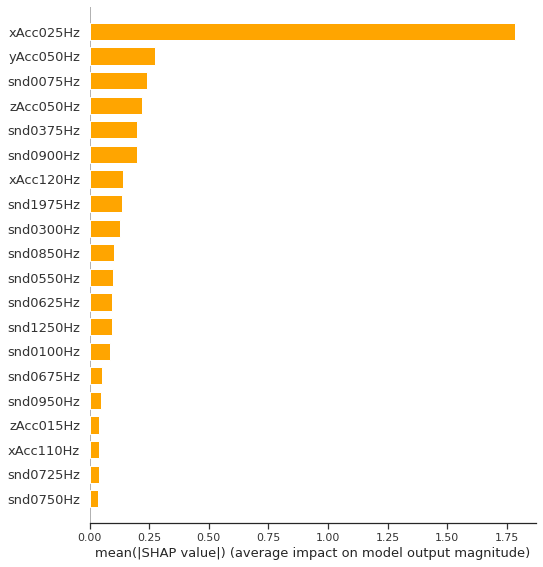

In [ ]:
shap.summary_plot(shap_values[4], x, plot_type="bar", color="orange")

7 - c75 (red)

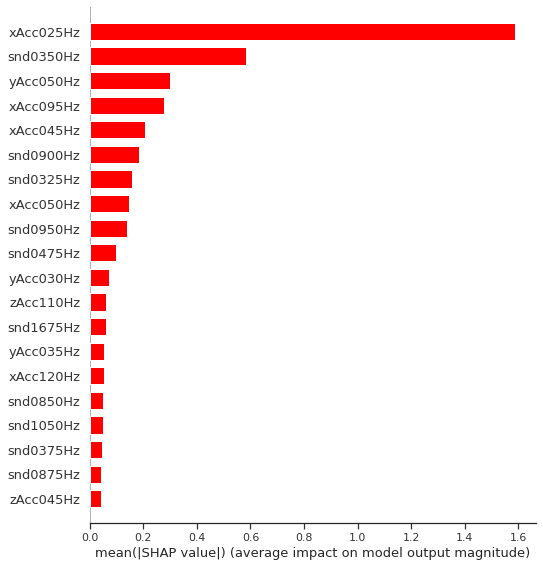

In [ ]:
shap.summary_plot(shap_values[5], x, plot_type="bar", color="red")

8 - vnt (green)

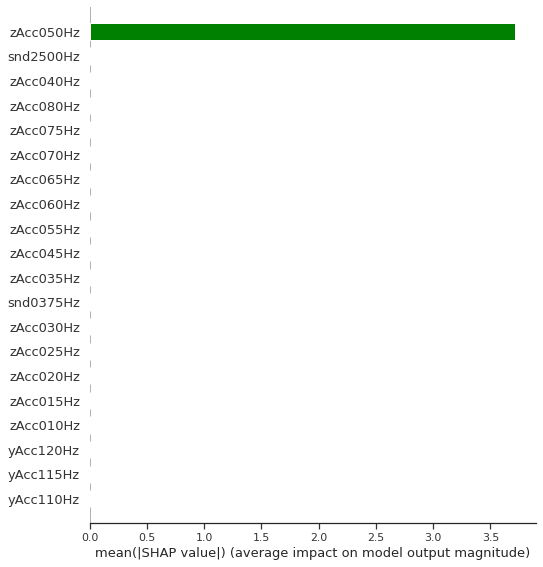

In [ ]:
shap.summary_plot(shap_values[6], x, plot_type="bar", color="green")

### Visualize the SHAP values with a heat map

Prepare:

In [ ]:
shap_values_02 = shap_values[0]
shap_values_03 = shap_values[1]
shap_values_04 = shap_values[2]
shap_values_05 = shap_values[3]
shap_values_06 = shap_values[4]
shap_values_07 = shap_values[5]
shap_values_08 = shap_values[6]

def mean_over_col(pre_array):
    """Get the mean of every column of an array

    Parameters
    ----------
    pre_array : numpy.array

    """
    # Check the shape of the given array
    num_rows, num_cols = pre_array.shape
    
    # Create a new empty array with the shape
    fin_array = np.empty([num_cols])
    
    for index in range(num_cols):
        fin_array[index] = statistics.mean(pre_array[:,index])
        
    
    return fin_array

m_shap_values_02 = mean_over_col(np.abs(shap_values_02))
m_shap_values_03 = mean_over_col(np.abs(shap_values_03))
m_shap_values_04 = mean_over_col(np.abs(shap_values_04))
m_shap_values_05 = mean_over_col(np.abs(shap_values_05))
m_shap_values_06 = mean_over_col(np.abs(shap_values_06))
m_shap_values_07 = mean_over_col(np.abs(shap_values_07))
m_shap_values_08 = mean_over_col(np.abs(shap_values_08))

mean_shap = pd.DataFrame(np.array([m_shap_values_02, 
                                   m_shap_values_03, 
                                   m_shap_values_04,
                                   m_shap_values_05,
                                   m_shap_values_06,
                                   m_shap_values_07,
                                   m_shap_values_08]), columns=x.columns, index = ["2:On", "3-Cap", "4:Out", "5: Unb", "6: c25", "7: c75", "8: vnt"])

mean_shap

,xAcc010Hz,xAcc015Hz,xAcc020Hz,xAcc025Hz,xAcc030Hz,xAcc035Hz,xAcc040Hz,xAcc045Hz,xAcc050Hz,xAcc055Hz,...,snd2275Hz,snd2300Hz,snd2325Hz,snd2350Hz,snd2375Hz,snd2400Hz,snd2425Hz,snd2450Hz,snd2475Hz,snd2500Hz
2:On,0.000000,0.000000,0.547850,1.782958,0.000603,0.000000,0.000000,0.000000,0.000000,0.002202,...,0.000000,0.002861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3-Cap,0.000000,0.000000,0.012442,0.402925,0.000000,0.000000,0.000000,0.434559,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4:Out,0.000915,0.127226,0.000000,0.704840,0.000000,0.000000,0.000000,0.000000,0.041372,0.002686,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001809
5: Unb,0.001054,0.002821,0.003208,1.901659,0.012306,0.000000,0.001028,0.058055,0.060836,0.000000,...,0.014523,0.033805,0.000645,0.000000,0.000000,0.024313,0.000000,0.000000,0.004451,0.000747
6: c25,0.002660,0.001293,0.008668,1.783748,0.000943,0.016902,0.003042,0.004713,0.005825,0.000000,...,0.031479,0.009761,0.000705,0.002840,0.002474,0.013275,0.011784,0.003263,0.024348,0.000000
7: c75,0.000910,0.012208,0.000000,1.586502,0.014341,0.000278,0.003452,0.207599,0.146343,0.000000,...,0.005981,0.001055,0.008632,0.001979,0.009768,0.005717,0.017928,0.002614,0.004178,0.010834
8: vnt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Plotting a heatmap for each class seperatly

2: on

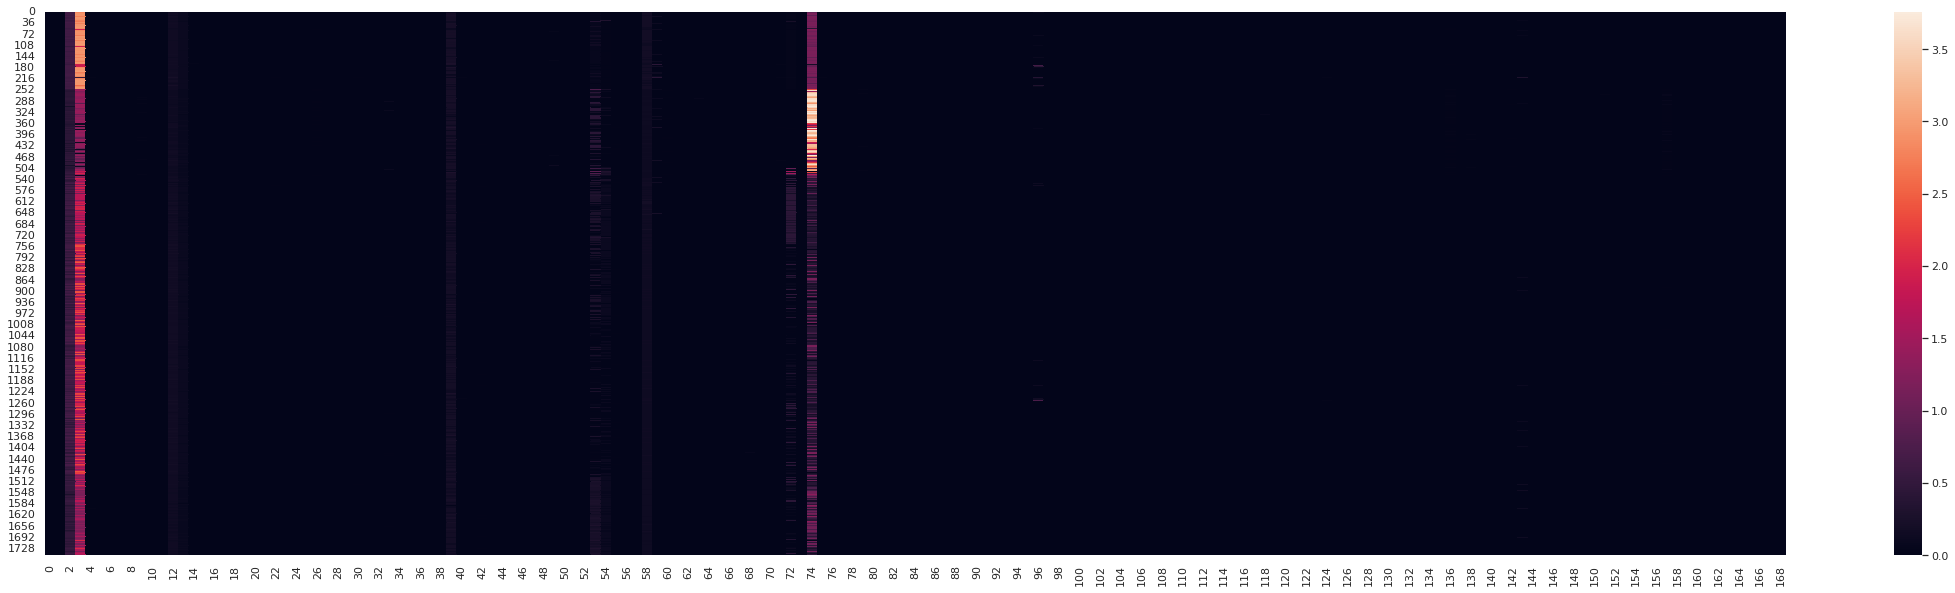

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(shap_values_02))

3: Cap 

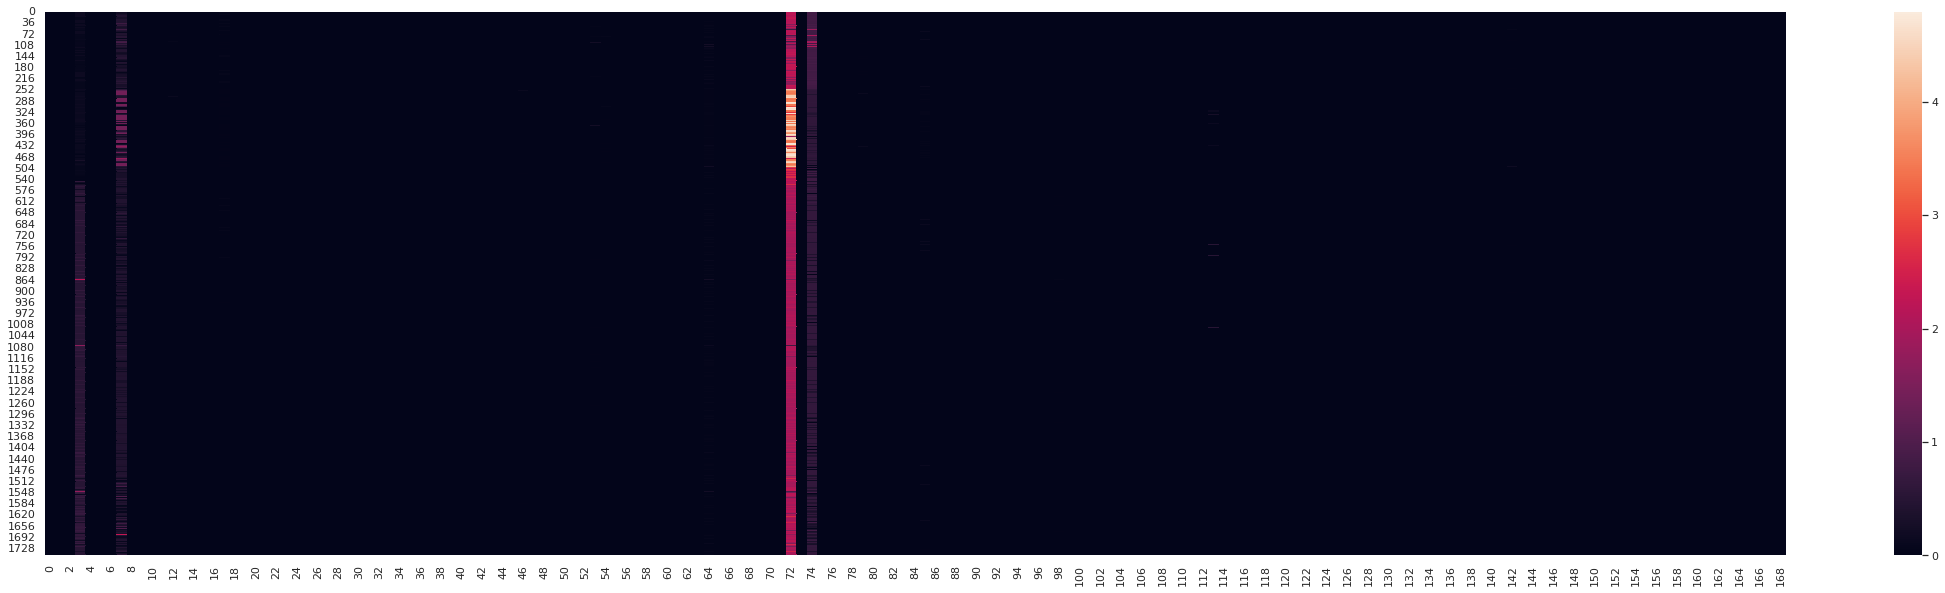

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(shap_values_03))

4: Out

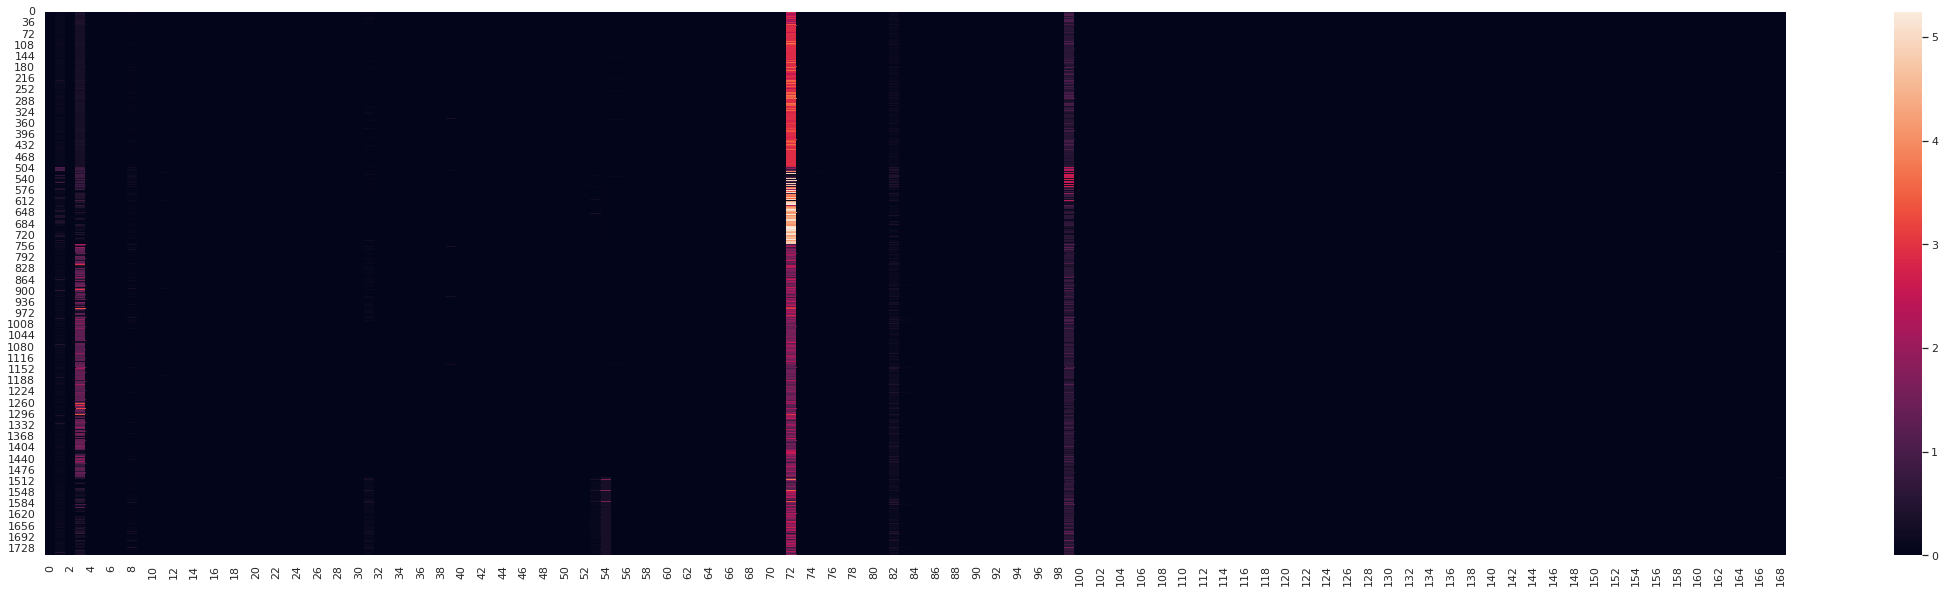

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(shap_values_04))

5: Unb

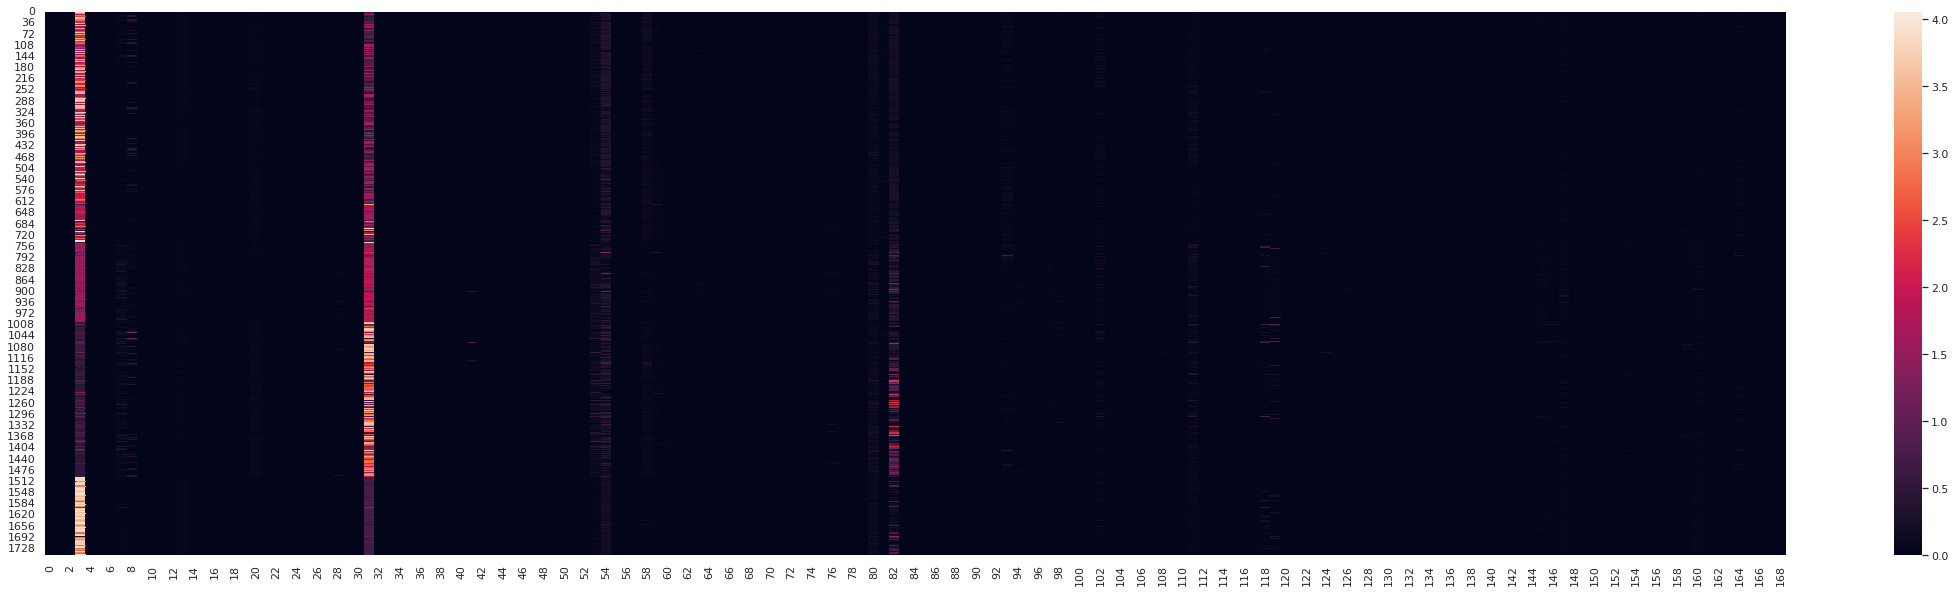

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(shap_values_05))

6: c25

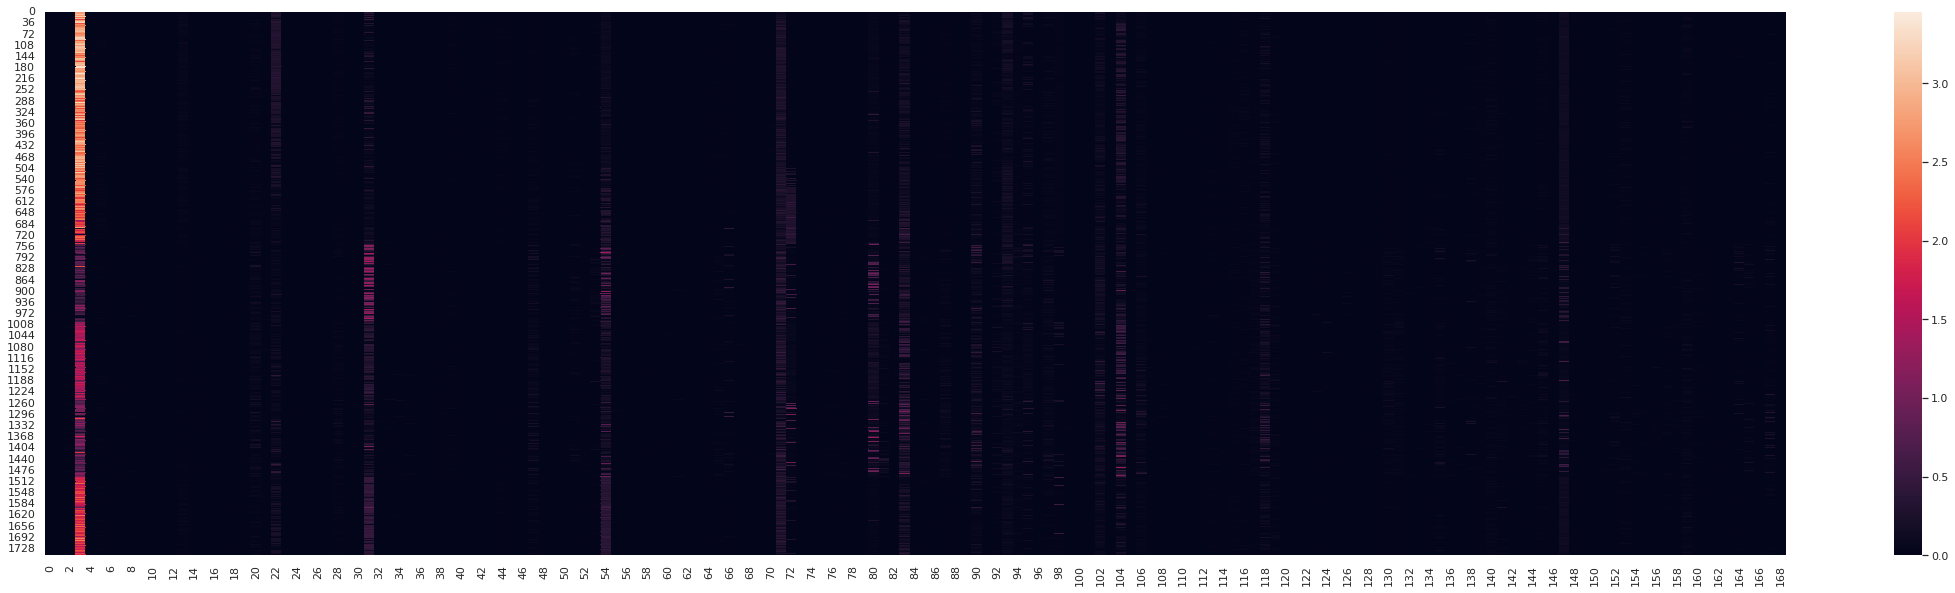

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(shap_values_06))

7: c75

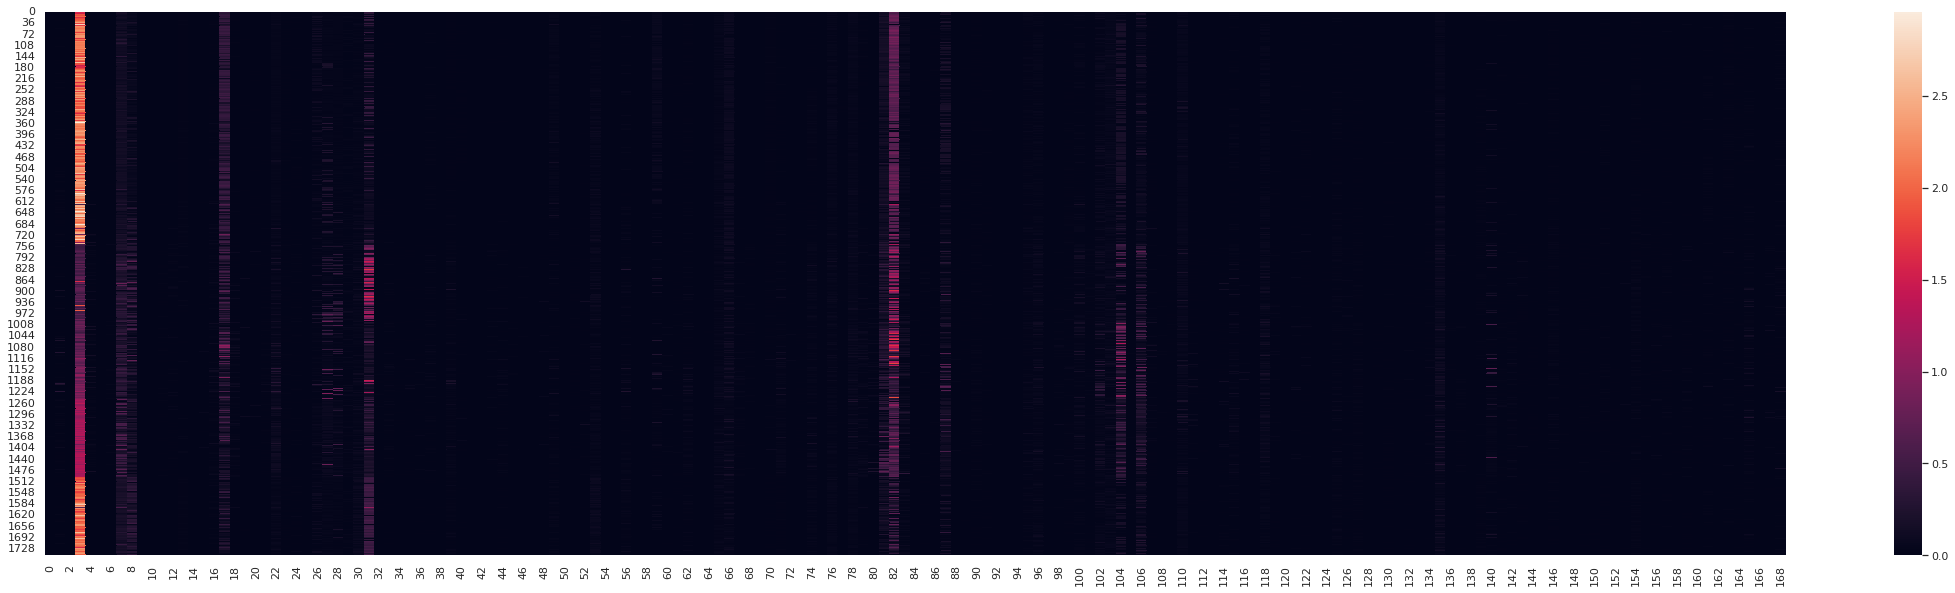

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(shap_values_07))

8: vnt

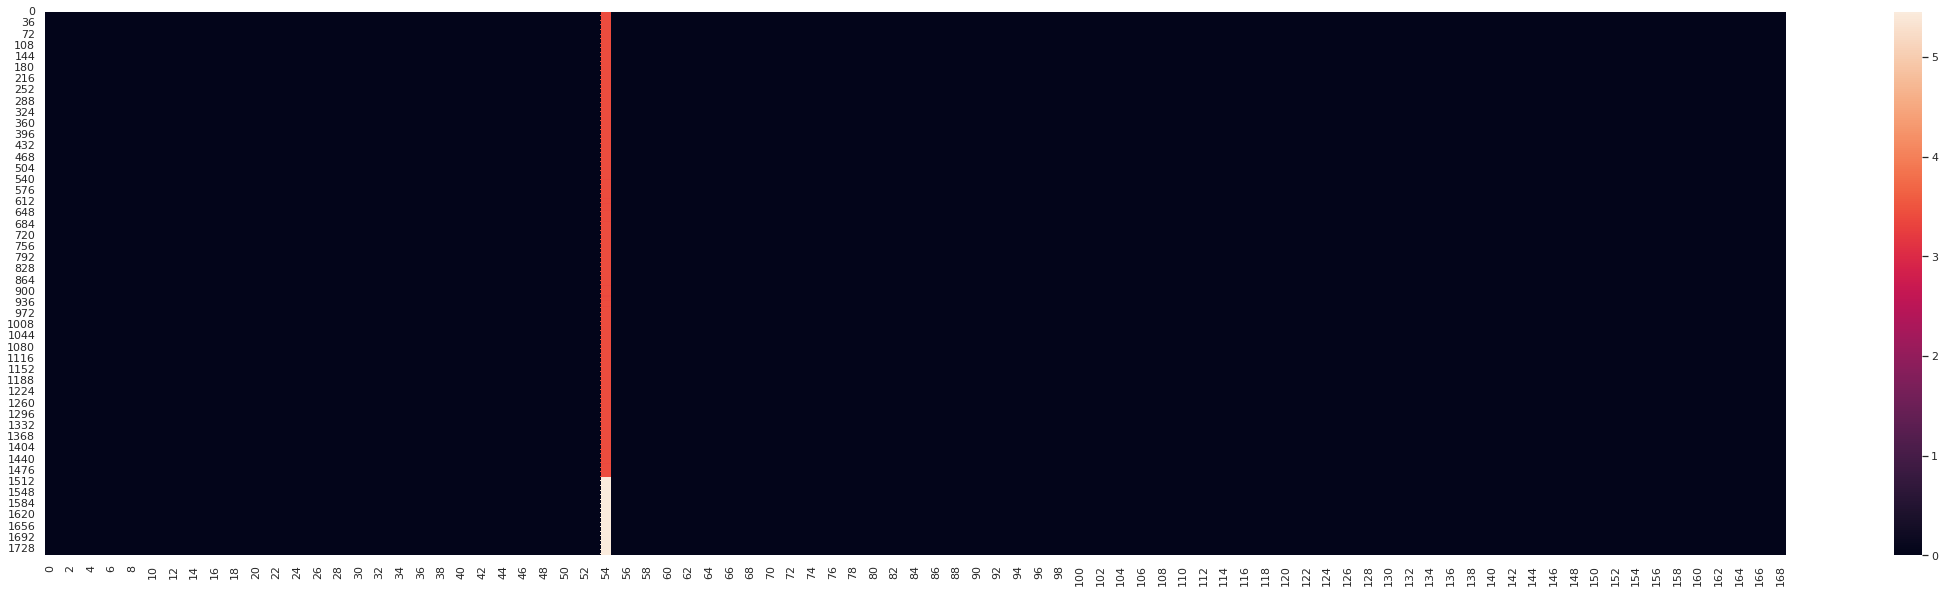

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(shap_values_08))

Plotting the entire heatmap for the whole dataset, divided into classes

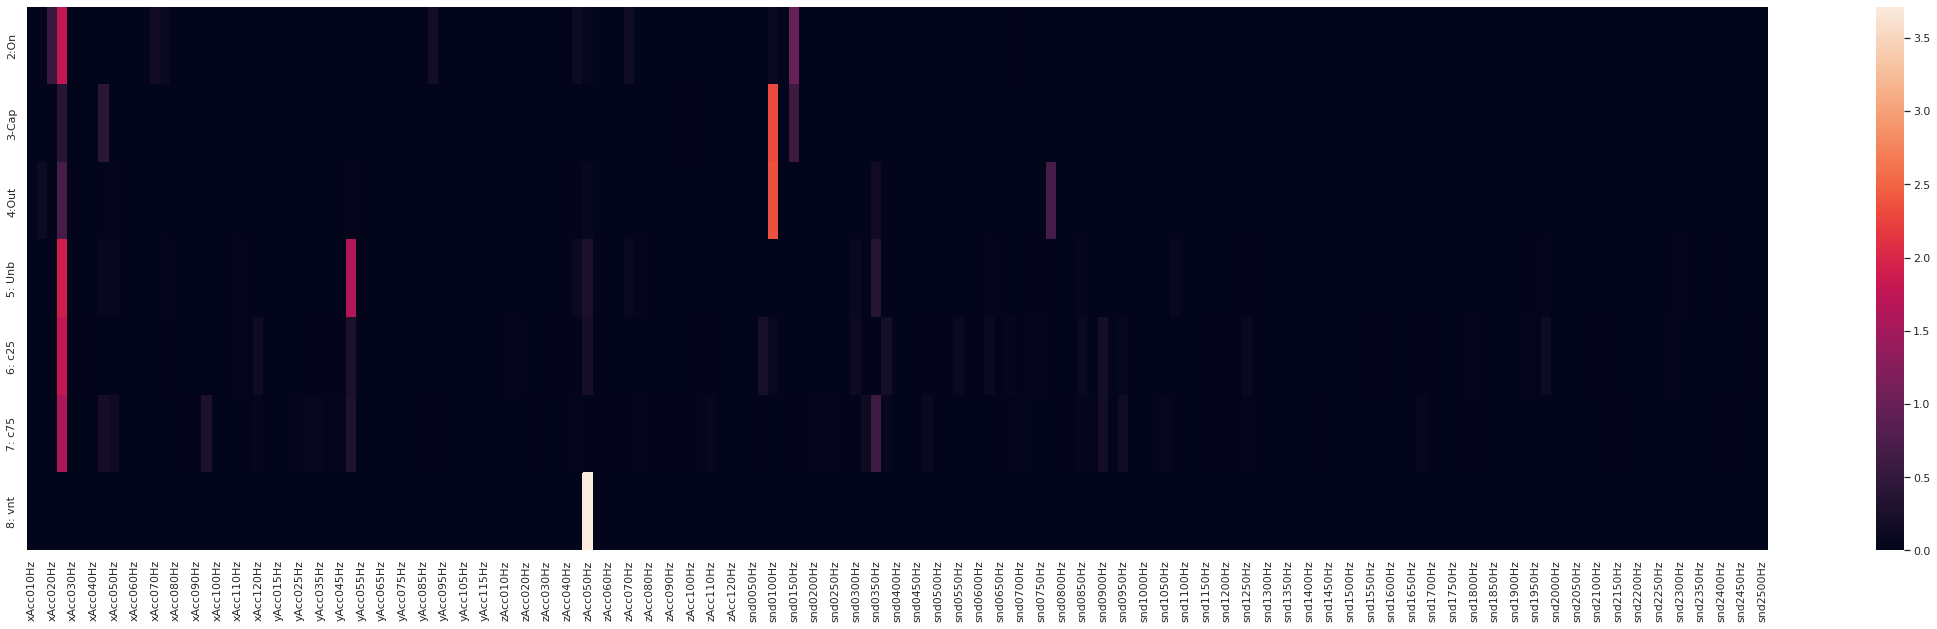

In [ ]:
plt.figure(figsize = (39,10))
ax = sns.heatmap(np.abs(mean_shap))

###Bumpplot - Analyse the correlation between the most important features and the max depth




*Defining a function for creating the bumpplot*

In [ ]:
def bumpchart(df, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)

        left_yaxis.plot(x, y, **line_args, solid_capstyle='round')
        
        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)
            
            #Adding see-through holes
            if holes:
                bg_color = left_yaxis.get_facecolor()
                left_yaxis.scatter(x, y, color= bg_color, **hole_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    left_yaxis.set_yticklabels(left_labels)
    right_yaxis.set_yticklabels(right_labels)
    
    # Setting the position of the far right axis so that it doesn't overlap with the right axis
    if show_rank_axis:
        far_right_yaxis.spines["right"].set_position(("axes", rank_axis_distance))
    
    return axes

In [ ]:
bump_data = pd.read_excel('feature_ranking_max_depth.xlsx', index_col=0)
bump_data = bump_data.transpose()
bump_data

,zAcc050Hz,xAcc025Hz,snd0100Hz,snd0150Hz,yAcc050Hz,xAcc045Hz,snd0350Hz,xAcc020Hz,snd0775Hz,snd0900Hz
1,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,NaN
2,2.0,1.0,3.0,4.0,5.0,7.0,8.0,6.0,9.0,NaN
3,2.0,1.0,3.0,5.0,4.0,7.0,6.0,8.0,9.0,NaN
4,3.0,1.0,2.0,5.0,4.0,7.0,6.0,8.0,9.0,10.0
5,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0
6,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0
7,3.0,1.0,2.0,5.0,4.0,8.0,6.0,9.0,7.0,10.0
8,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0
9,3.0,1.0,2.0,5.0,4.0,8.0,6.0,9.0,7.0,10.0
10,3.0,1.0,2.0,5.0,4.0,7.0,6.0,9.0,8.0,10.0


In [ ]:
print(bump_data)

    zAcc050Hz  xAcc025Hz  snd0100Hz  snd0150Hz  yAcc050Hz  xAcc045Hz  \
1         1.0        2.0        3.0        4.0        5.0        6.0   
2         2.0        1.0        3.0        4.0        5.0        7.0   
3         2.0        1.0        3.0        5.0        4.0        7.0   
4         3.0        1.0        2.0        5.0        4.0        7.0   
5         3.0        1.0        2.0        5.0        4.0        7.0   
6         3.0        1.0        2.0        5.0        4.0        7.0   
7         3.0        1.0        2.0        5.0        4.0        8.0   
8         3.0        1.0        2.0        5.0        4.0        7.0   
9         3.0        1.0        2.0        5.0        4.0        8.0   
10        3.0        1.0        2.0        5.0        4.0        7.0   

    snd0350Hz  xAcc020Hz  snd0775Hz  snd0900Hz  
1         7.0        8.0        9.0        NaN  
2         8.0        6.0        9.0        NaN  
3         6.0        8.0        9.0        NaN  
4         6

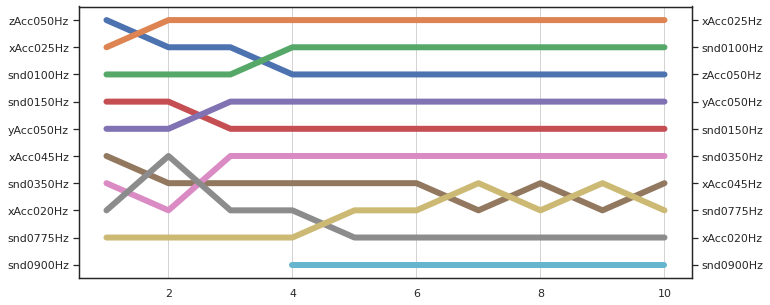

In [ ]:
plt.figure(figsize=(11, 5))

[laxis, raxis] = bumpchart(bump_data, show_rank_axis= False,
                           scatter= False,
                           holes = True,
                           line_args= {"linewidth": 6, "alpha": 1})

laxis.xaxis.grid(color='lightgray', linestyle='solid')

plt.show()

# Evaluation
The following evaluation system is used to classify the results and the quality.
On the one hand, the key figures Accuracy and F1-Score of the XGBoost are compared with different training data.
On the other hand, other types of models (KNN and SVM) are trained with this data and their key figures are also evaluated.
The three training data sets consist of: 1. the data set with all features 2. the 10 most important features from TreeSHAP and 3.
10 manually choosed features (random).



In [ ]:
# Get the important data
imp_data = raw_data[['xAcc025Hz', 
                    'snd0100Hz', 
                    'zAcc050Hz', 
                    'yAcc050Hz', 
                    'snd0150Hz', 
                    'snd0350Hz', 
                    'xAcc045Hz', 
                    'snd0775Hz', 
                    'xAcc020Hz', 
                    'snd0900Hz']]
id = raw_data['ID']
df_imp_data = pd.concat([id, imp_data], axis = 1)

x_imp = df_imp_data.drop('ID', axis = 1)
y_imp = df_imp_data['ID']

In [ ]:
# Get the random Data (these are selected manually)
rand_data = raw_data[['xAcc100Hz',
                      'snd0500Hz',
                      'zAcc080Hz',
                      'yAcc010Hz',
                      'snd1625Hz',
                      'snd2475Hz',
                      'xAcc060Hz',
                      'snd0300Hz',
                      'yAcc120Hz',
                      'zAcc015Hz']]

df_rand_data = pd.concat([id, rand_data], axis = 1)

x_rand = df_rand_data.drop('ID', axis = 1)
y_rand = df_rand_data['ID']

The following abbreviations are used to identify the data

with all Data = a

with the important Data = i

with the random Data = r

The train_test_data for the Support-Vector-Machines got an additional indices s because the Data must be scaled

Example: all Features tree = x_train_a

Example: random Features SVM = x_train_sr


In [ ]:
# For KNN and XGBoost we can use the same train_test_split but not for SVM (Because the Data must be scaled)
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(x, y, test_size=0.2, random_state=7)
x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(x_imp,y_imp, test_size=0.2, random_state=7)
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_rand,y_rand, test_size=0.2, random_state=7)

x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(x, y, test_size=0.2, random_state=7)
x_train_si, x_test_si, y_train_si, y_test_si = train_test_split(x_imp, y_imp, test_size=0.2, random_state=7)
x_train_sr, x_test_sr, y_train_sr, y_test_sr = train_test_split(x_rand, y_rand, test_size=0.2, random_state=7)

# Scale the train_test_data for the Support Vector Machine
scaler_all = StandardScaler()
scaler_imp = StandardScaler()
scaler_rand = StandardScaler()

scaler_all.fit(x_train_sa)
scaler_imp.fit(x_train_si)
scaler_rand.fit(x_train_sr)

x_train_sa = scaler_all.transform(x_train_sa)
x_train_si = scaler_imp.transform(x_train_si)
x_train_sr = scaler_rand.transform(x_train_sr)

x_test_sa = scaler_all.transform(x_test_sa)
x_test_si = scaler_imp.transform(x_test_si)
x_test_sr = scaler_rand.transform(x_test_sr)

## Tree

### with all data

In [ ]:
xgb_all = xgboost.XGBClassifier(silent = 0,
                              max_depth = 6)
xgb_all.fit(x_train_a, y_train_a)
xgb_all.score(x_test_a, y_test_a)

0.9685714285714285

In [ ]:
xgb_all_pred = xgb_all.predict(x_test_a)
print(classification_report(y_test_a, xgb_all_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        47
           5       0.98      0.93      0.95        43
           6       0.88      0.89      0.88        47
           7       0.91      0.93      0.92        45
           8       1.00      1.00      1.00        54

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



In [ ]:
print(metrics.confusion_matrix(y_test_a,xgb_all_pred))

NameError: ignored

### with the important data

In [ ]:
xgb_imp = xgboost.XGBClassifier(silent = 0,
                                 max_depth = 6)
xgb_imp.fit(x_train_i, y_train_i)
xgb_imp.score(x_test_i, y_test_i)

0.92

In [ ]:
xgb_imp_pred = xgb_imp.predict(x_test_i)
print(classification_report(y_test_i, xgb_imp_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        47
           5       0.95      0.91      0.93        43
           6       0.76      0.68      0.72        47
           7       0.69      0.80      0.74        45
           8       1.00      1.00      1.00        54

    accuracy                           0.92       350
   macro avg       0.92      0.91      0.91       350
weighted avg       0.92      0.92      0.92       350



In [ ]:
print(metrics.confusion_matrix(y_test_i,xgb_imp_pred))

[[54  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 47  0  0  0  0]
 [ 0  0  0 39  1  3  0]
 [ 0  0  0  2 32 13  0]
 [ 0  0  0  0  9 36  0]
 [ 0  0  0  0  0  0 54]]


###with random data



In [ ]:
xgb_rand = xgboost.XGBClassifier(silent = 0,
                                 max_depth = 6)
xgb_rand.fit(x_train_r, y_train_r)
xgb_rand.score(x_test_r, y_test_r)

0.3514285714285714

In [ ]:
xgb_rand_pred = xgb_rand.predict(x_test_r)
print(classification_report(y_test_r, xgb_rand_pred))

              precision    recall  f1-score   support

           2       0.35      0.43      0.38        54
           3       0.67      0.57      0.61        60
           4       0.36      0.38      0.37        47
           5       0.28      0.33      0.30        43
           6       0.16      0.17      0.16        47
           7       0.24      0.13      0.17        45
           8       0.35      0.37      0.36        54

    accuracy                           0.35       350
   macro avg       0.34      0.34      0.34       350
weighted avg       0.36      0.35      0.35       350



In [ ]:
print(metrics.confusion_matrix(y_test_r,xgb_rand_pred))

[[23  2 10  3  9  0  7]
 [ 1 34  3  6  5  5  6]
 [14  0 18  3  7  1  4]
 [ 5  4  3 14  6  7  4]
 [12  5  6  6  8  3  7]
 [ 4  2  8 11  5  6  9]
 [ 7  4  2  7 11  3 20]]


## KNN

### with all data

In [ ]:
KNN_all = KNeighborsClassifier(n_neighbors=3)
KNN_all.fit(x_train_a, y_train_a)
KNN_all.score(x_test_a, y_test_a)

0.9142857142857143

In [ ]:
KNN_all_pred = KNN_all.predict(x_test_a)
print(classification_report(y_test_a, KNN_all_pred))

              precision    recall  f1-score   support

           2       0.98      1.00      0.99        54
           3       1.00      0.98      0.99        60
           4       1.00      0.94      0.97        47
           5       0.93      0.88      0.90        43
           6       0.73      0.70      0.72        47
           7       0.73      0.84      0.78        45
           8       1.00      1.00      1.00        54

    accuracy                           0.91       350
   macro avg       0.91      0.91      0.91       350
weighted avg       0.92      0.91      0.92       350



In [ ]:
print(metrics.confusion_matrix(y_test_a,KNN_all_pred))

[[54  0  0  0  0  0  0]
 [ 1 59  0  0  0  0  0]
 [ 0  0 44  0  2  1  0]
 [ 0  0  0 38  3  2  0]
 [ 0  0  0  3 33 11  0]
 [ 0  0  0  0  7 38  0]
 [ 0  0  0  0  0  0 54]]


### with the important data

In [ ]:
KNN_imp = KNeighborsClassifier(n_neighbors=3)
KNN_imp.fit(x_train_i, y_train_i)
KNN_imp.score(x_test_i, y_test_i)

0.8085714285714286

In [ ]:
KNN_imp_pred = KNN_imp.predict(x_test_i)
print(classification_report(y_test_i, KNN_imp_pred))

              precision    recall  f1-score   support

           2       0.83      0.91      0.87        54
           3       0.89      0.83      0.86        60
           4       0.98      0.94      0.96        47
           5       0.81      0.88      0.84        43
           6       0.58      0.53      0.56        47
           7       0.50      0.51      0.51        45
           8       1.00      1.00      1.00        54

    accuracy                           0.81       350
   macro avg       0.80      0.80      0.80       350
weighted avg       0.81      0.81      0.81       350



In [ ]:
print(metrics.confusion_matrix(y_test_i,KNN_imp_pred))

[[49  5  0  0  0  0  0]
 [ 9 50  1  0  0  0  0]
 [ 1  1 44  0  0  1  0]
 [ 0  0  0 38  1  4  0]
 [ 0  0  0  4 25 18  0]
 [ 0  0  0  5 17 23  0]
 [ 0  0  0  0  0  0 54]]


###with random data



In [ ]:
KNN_rand = KNeighborsClassifier(n_neighbors=3)
KNN_rand.fit(x_train_r, y_train_r)
KNN_rand.score(x_test_r, y_test_r)

0.2714285714285714

In [ ]:
KNN_rand_pred = KNN_rand.predict(x_test_r)
print(classification_report(y_test_r, KNN_rand_pred))

              precision    recall  f1-score   support

           2       0.28      0.56      0.37        54
           3       0.39      0.37      0.38        60
           4       0.20      0.21      0.21        47
           5       0.17      0.19      0.18        43
           6       0.23      0.15      0.18        47
           7       0.17      0.09      0.12        45
           8       0.42      0.26      0.32        54

    accuracy                           0.27       350
   macro avg       0.27      0.26      0.25       350
weighted avg       0.27      0.27      0.26       350



In [ ]:
print(metrics.confusion_matrix(y_test_r,KNN_rand_pred))

[[30  3  5  9  1  2  4]
 [13 22  9  5  6  4  1]
 [18  3 10  7  5  1  3]
 [14  3  6  8  2  5  5]
 [10 15  3  6  7  3  3]
 [12  7  9  6  4  4  3]
 [12  4  7  7  5  5 14]]


## SVM


### with all data

In [ ]:
SVM_all = SVC(kernel = "linear", C = 1)
SVM_all.fit(x_train_sa, y_train_sa)

SVC(C=1, kernel='linear')

In [ ]:
SVM_all_pred = SVM_all.predict(x_test_sa)
print(classification_report(y_test_sa, SVM_all_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        47
           5       1.00      1.00      1.00        43
           6       0.95      0.81      0.87        47
           7       0.83      0.96      0.89        45
           8       1.00      1.00      1.00        54

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



In [ ]:
print(metrics.confusion_matrix(y_test_sa,SVM_all_pred))

[[54  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 47  0  0  0  0]
 [ 0  0  0 43  0  0  0]
 [ 0  0  0  0 38  9  0]
 [ 0  0  0  0  2 43  0]
 [ 0  0  0  0  0  0 54]]


### with the important data

In [ ]:
SVM_imp = SVC(kernel = "linear", C = 1)
SVM_imp.fit(x_train_si, y_train_si)

SVC(C=1, kernel='linear')

In [ ]:
SVM_imp_pred = SVM_imp.predict(x_test_si)
print(classification_report(y_test_si, SVM_imp_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        47
           5       0.95      0.93      0.94        43
           6       0.78      0.66      0.71        47
           7       0.70      0.82      0.76        45
           8       1.00      1.00      1.00        54

    accuracy                           0.92       350
   macro avg       0.92      0.92      0.92       350
weighted avg       0.93      0.92      0.92       350



In [ ]:
print(metrics.confusion_matrix(y_test_si,SVM_imp_pred))

[[54  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 47  0  0  0  0]
 [ 0  0  0 40  1  2  0]
 [ 0  0  0  2 31 14  0]
 [ 0  0  0  0  8 37  0]
 [ 0  0  0  0  0  0 54]]


###with random data



In [ ]:
SVM_rand = SVC(kernel = "linear", C = 1)
SVM_rand.fit(x_train_sr, y_train_sr)
SVM_rand.score(x_test_sr, y_test_sr)

0.36857142857142855

In [ ]:
SVM_rand_pred = SVM_rand.predict(x_test_sr)
print(classification_report(y_test_sr, SVM_rand_pred))

              precision    recall  f1-score   support

           2       0.35      0.54      0.42        54
           3       0.62      0.62      0.62        60
           4       0.27      0.36      0.31        47
           5       0.33      0.33      0.33        43
           6       0.14      0.09      0.11        47
           7       0.20      0.04      0.07        45
           8       0.41      0.48      0.44        54

    accuracy                           0.37       350
   macro avg       0.33      0.35      0.33       350
weighted avg       0.34      0.37      0.34       350



In [ ]:
print(metrics.confusion_matrix(y_test_sr,SVM_rand_pred))

[[29  3 10  2  4  0  6]
 [ 3 37  6  6  3  2  3]
 [17  2 17  4  4  0  3]
 [ 3  3  7 14  3  5  8]
 [14 10  8  2  4  1  8]
 [ 6  1  8 11  7  2 10]
 [11  4  6  3  4  0 26]]


# Conclusion and future work

The results show that TreeSHAP is an efficient method for determining the features of the dataset that are relevant across models. In addition, a clearly audible difference between the individual classes could be detected during the extraction of the audio files. By reducing the dataset to the 10 most important properties using TreeSHAP, the dimensionality could be greatly reduced without significant loss of information (XGB). In the future, a generalization of the applied methodology can be explored by applying it to other datasets. The features contained in the reduced dataset can be investigated for their physical cause. Also, frequency filters could be applied to the important frequencies to produce an output signal for each class upon error detection. Furthermore, the approach can be further investigated as a dimensionality reduction technique. 